In [5]:
using PyPlot
using Distributions

include("utils.jl")
include("ode.jl")

srand(42);

In [6]:
# Simulate calculates the n time measurements at which the pendulum take
# a null angle for a given gravitational constant 
function simulate(n, g; Θ₀ = 5*pi/180, l = 7.4, τ = 0.01)
    n_times = 0
    times = zeros(n)

    t = 0
    
    Θ = [Θ₀, 0]
    dΘ = Θ -> [Θ[2], -(Θ[2]/2 + g*sin(Θ[1])/l)]
    
    while n_times < n
        Θₙ = rk4(dΘ, Θ, τ)
        
        # if the angle has changed sign, we linearly approximate the intersection
        # with 0
        if Θ[1] * Θₙ[1] <= 0
            t_intersect = t - τ*Θ[1]/(Θₙ[1] - Θ[1])
            n_times += 1
            times[n_times] = t_intersect
        end
        
        Θ = Θₙ
        t += τ
    end
    
    times
end

simulate (generic function with 1 method)

In [7]:
function MetropolisHastings(K, Π, γ, x₀)
    X = zeros(K, length(x₀))
    w = MvNormal(γ^2*eye(length(x₀)))
    x = x₀
    πₓ = Π(x)
    accepted = 0
    for k=1:K
        y = x + rand(w)
        πₙ = Π(y)
        if rand() < min(1, πₙ / πₓ)
            x = y
            πₓ = πₙ
            accepted += 1
        end
        X[k,:] = x
    end
    X, accepted
end;

In [13]:
measurements = open(readdlm,"../data/original_data")
measurements_mask = abs(sign(measurements))

n_measurements = size(measurements)[1]
max_intersects = size(measurements)[2]

prior = dunif(5, 15)
likelihood = g ->
    let
        d = dnorm(0, 1)
        t = simulate(max_intersects, g)
        exp(sumoveri(i -> sum(log.(d.(measurements_mask[i,:] .* (measurements[i,:] - t)))), n_measurements))
    end
unnormalized_posterior = m -> prior(m[1])*likelihood(m[1])

samples, n_accepted = MetropolisHastings(10000, unnormalized_posterior, 0.1, rand(1)*10 + 5)

(
[10.1654; 10.1418; … ; 9.64515; 9.64515],

5246)

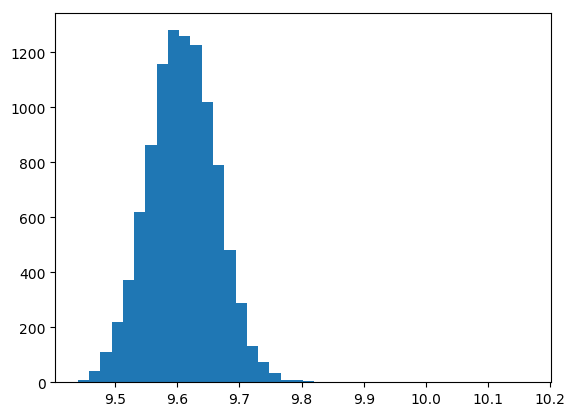

9.608477236276263

In [14]:
PyPlot.plt[:hist](samples[:,1], 40);
mean(samples[:,1])